<a href="https://colab.research.google.com/github/J-H-LEE-std/dne-cnn/blob/main/emnist_dnc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install emnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import tensorflow as tf
import numpy as np
import os, random

from emnist import extract_training_samples, extract_test_samples
from tqdm import tqdm
from functools import reduce

In [4]:
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [5]:
train_x, train_y = extract_training_samples('byclass')
test_x, test_y = extract_test_samples('byclass')

train_x = train_x.reshape(-1,28,28,1) / 255
test_x = test_x.reshape(-1,28,28,1) / 255

numeric = [x for x in range(10)]
letter = [w for w in range(10, 62)]
upper = [y for y in range(10, 36)]
lower = [z for z in range(36, 62)]

train_y_type = np.array([1 if i in letter else 0 for i in train_y])
test_y_type = np.array([1 if i in letter else 0 for i in test_y])

print(train_y)
print(train_y_type)

[35 36  6 ...  5 11 22]
[1 1 0 ... 0 1 1]


In [6]:
class cnn(tf.keras.Model):
  def __init__(self, output):
    super(cnn, self).__init__()
    self.resize = tf.keras.layers.Resizing(224, 224, interpolation='bilinear')
    self.conv1 = tf.keras.layers.Conv2D(kernel_size=(3,3), filters=16, activation='relu')
    self.conv2 = tf.keras.layers.Conv2D(kernel_size=(3,3), filters=32, activation='relu')
    self.pool = tf.keras.layers.MaxPooling2D((2, 2))
    self.flatten = tf.keras.layers.Flatten()
    self.d1 = tf.keras.layers.Dense(32, activation='relu')
    self.d2 = tf.keras.layers.Dense(output, activation='softmax')

  def call(self, x):
    x = self.resize(x)
    x = tf.keras.layers.Concatenate()([x, x, x])
    x = self.conv1(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.flatten(x)
    x = self.d1(x)
    return self.d2(x)

class resnet(tf.keras.Model):
    def __init__(self, output):
      super().__init__()
      self.resize = tf.keras.layers.Resizing(224, 224, interpolation='bilinear')          
      self.resnet = tf.keras.applications.resnet50.ResNet50(include_top=False, pooling='avg')
      self.dropout = tf.keras.layers.Dropout(0.50)
      self.dense = tf.keras.layers.Dense(output, activation='softmax')
        
    def call(self, x):   
      x = self.resize(x)
      x = tf.keras.layers.Concatenate()([x, x, x])
      x = self.resnet(x)
      x = self.dropout(x)
      return self.dense(x)

In [7]:
model_cnn = cnn(62)
model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

hist_cnn = model_cnn.fit(
    train_x,
    train_y,
    epochs=5,
    batch_size=128,
    validation_data=(test_x, test_y)
)

model_res = resnet(62)
model_res.compile(
    optimizer=tf.keras.optimizers.SGD(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

hist_res = model_res.fit(
    train_x,
    train_y,
    epochs=10,
    batch_size=128,
    validation_data=(test_x, test_y)
)


Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


5453/5453 [==============================] - 161s 27ms/step - loss: 0.7610 - sparse_categorical_accuracy: 0.7678 - val_loss: 0.5704 - val_sparse_categorical_accuracy: 0.8127
Epoch 2/5
5453/5453 [==============================] - 135s 25ms/step - loss: 0.5389 - sparse_categorical_accuracy: 0.8211 - val_loss: 0.5403 - val_sparse_categorical_accuracy: 0.8153
Epoch 3/5
5453/5453 [==============================] - 135s 25ms/step - loss: 0.4868 - sparse_categorical_accuracy: 0.8341 - val_loss: 0.5053 - val_sparse_categorical_accuracy: 0.8298
Epoch 4/5
5453/5453 [==============================] - 136s 25ms/step - loss: 0.4502 - sparse_categorical_accuracy: 0.8434 - val_loss: 0.5153 - val_sparse_categorical_accuracy: 0.8275
Epoch 5/5
94781440/94765736 [==============================] - 0s 0us/step
Epoch 1/10
5453/5453 [==============================] - 1048s 191ms/step - loss: 0.9131 - sparse_categorical_accuracy: 0.7491 - val_loss: 0.4189 - val_sparse_categorical_accuracy: 0.8536
Epoch 2/10
5

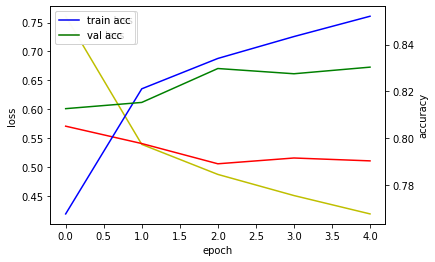

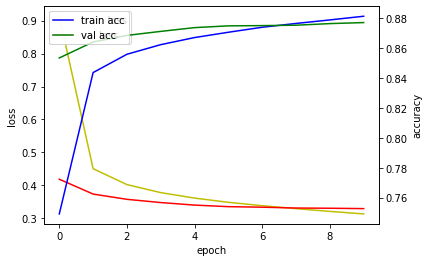

In [8]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist_cnn.history['loss'], 'y', label='train loss')
loss_ax.plot(hist_cnn.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist_cnn.history['sparse_categorical_accuracy'], 'b', label='train acc')
acc_ax.plot(hist_cnn.history['val_sparse_categorical_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

fig_2, loss2_ax = plt.subplots()
acc2_ax = loss2_ax.twinx()

loss2_ax.plot(hist_res.history['loss'], 'y', label='train loss')
loss2_ax.plot(hist_res.history['val_loss'], 'r', label='val loss')
loss2_ax.set_xlabel('epoch')
loss2_ax.set_ylabel('loss')
loss2_ax.legend(loc='upper left')

acc2_ax.plot(hist_res.history['sparse_categorical_accuracy'], 'b', label='train acc')
acc2_ax.plot(hist_res.history['val_sparse_categorical_accuracy'], 'g', label='val acc')
acc2_ax.set_ylabel('accuracy')
acc2_ax.legend(loc='upper left')

plt.show()

In [9]:
def split_numornot(x, y):
  number = []
  digit = []
  for i, j in zip(tqdm(x), y):
    number.append(i) if j < 10 else digit.append(i)

  return (np.array(number), np.array(digit))

print('Dividing training set...')
train_number_x, train_digit_x = split_numornot(train_x, train_y)
train_number_y, train_digit_y = split_numornot(train_y, train_y)
print('Dividing test set...')
test_number_x, test_digit_x = split_numornot(test_x, test_y)
test_number_y, test_digit_y = split_numornot(test_y, test_y)
train_digit_y = train_digit_y - 10
test_digit_y = test_digit_y - 10

Dividing training set...


100%|██████████| 697932/697932 [00:01<00:00, 510240.04it/s]


Dividing test set...


100%|██████████| 116323/116323 [00:00<00:00, 514194.02it/s]


Epoch 1/60
5453/5453 [==============================] - 131s 24ms/step - loss: 0.4030 - sparse_categorical_accuracy: 0.8117 - val_loss: 0.3359 - val_sparse_categorical_accuracy: 0.8487
Epoch 2/60
5453/5453 [==============================] - 130s 24ms/step - loss: 0.3265 - sparse_categorical_accuracy: 0.8552 - val_loss: 0.3148 - val_sparse_categorical_accuracy: 0.8613
Epoch 3/60
5453/5453 [==============================] - 130s 24ms/step - loss: 0.3073 - sparse_categorical_accuracy: 0.8646 - val_loss: 0.3032 - val_sparse_categorical_accuracy: 0.8663
Epoch 4/60
5453/5453 [==============================] - 130s 24ms/step - loss: 0.2962 - sparse_categorical_accuracy: 0.8695 - val_loss: 0.2958 - val_sparse_categorical_accuracy: 0.8701
Epoch 5/60
5453/5453 [==============================] - 130s 24ms/step - loss: 0.2889 - sparse_categorical_accuracy: 0.8728 - val_loss: 0.2971 - val_sparse_categorical_accuracy: 0.8706
Epoch 6/60
5453/5453 [==============================] - 131s 24ms/step - lo

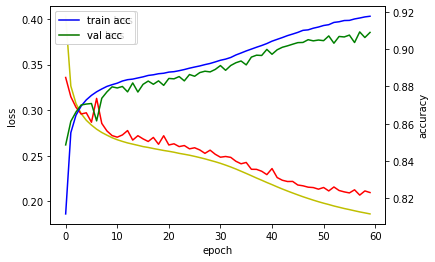

In [10]:
model_cnn_root = cnn(2)
model_cnn_root.compile(
    optimizer=tf.keras.optimizers.SGD(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

hist_cnn_root = model_cnn_root.fit(
    train_x,
    train_y_type,
    epochs=60,
    batch_size=128,
    validation_data=(test_x, test_y_type)
)

fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist_cnn_root.history['loss'], 'y', label='train loss')
loss_ax.plot(hist_cnn_root.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(hist_cnn_root.history['sparse_categorical_accuracy'], 'b', label='train acc')
acc_ax.plot(hist_cnn_root.history['val_sparse_categorical_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [11]:
model_resnet_number = resnet(10)
model_resnet_number.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

hist_resnet_number = model_resnet_number.fit(
    train_number_x,
    train_number_y,
    epochs=10,
    batch_size=128,
    validation_data=(test_number_x, test_number_y)
)

model_resnet_digit = resnet(52)
model_resnet_digit.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

hist_resnet_digit = model_resnet_digit.fit(
    train_digit_x,
    train_digit_y,
    epochs=5,
    batch_size=128,
    validation_data=(test_digit_x, test_digit_y)
)

Epoch 1/10
2696/2696 [==============================] - 526s 193ms/step - loss: 0.0303 - sparse_categorical_accuracy: 0.9915 - val_loss: 0.0156 - val_sparse_categorical_accuracy: 0.9957
Epoch 2/10
2696/2696 [==============================] - 518s 192ms/step - loss: 0.0152 - sparse_categorical_accuracy: 0.9959 - val_loss: 0.0137 - val_sparse_categorical_accuracy: 0.9961
Epoch 3/10
2696/2696 [==============================] - 518s 192ms/step - loss: 0.0122 - sparse_categorical_accuracy: 0.9966 - val_loss: 0.0177 - val_sparse_categorical_accuracy: 0.9955
Epoch 4/10
2696/2696 [==============================] - 518s 192ms/step - loss: 0.0101 - sparse_categorical_accuracy: 0.9973 - val_loss: 0.0174 - val_sparse_categorical_accuracy: 0.9955
Epoch 5/10
2696/2696 [==============================] - 519s 192ms/step - loss: 0.0082 - sparse_categorical_accuracy: 0.9978 - val_loss: 0.0123 - val_sparse_categorical_accuracy: 0.9968
Epoch 6/10
2696/2696 [==============================] - 519s 192ms/ste

In [12]:
class test():
  def __init__(self, x_test, y_test):
    self.test_x = x_test
    self.test_y = y_test
    self.conf = np.zeros(shape=(62, 62), dtype=np.int32)

  def confuse_matrix(self):
    print(self.conf)
    sum_acc = reduce(lambda x, y: x + y, [self.conf[i][i] for i in range(62)])
    print(f"acc = {sum_acc / np.sum(self.conf)}")

  def test(self, root, child1, child2):
    childnode = [child1, child2]
    for x, y in zip(tqdm(self.test_x), self.test_y):
      final_x = x.reshape(-1,28,28,1)
      mid_result = root.predict(final_x)
      result = childnode[np.argmax(mid_result)](final_x)
      pred = np.argmax(result) if np.argmax(mid_result) == 0 else np.argmax(result)+10
      self.conf[pred][y] += 1
  
  def export_conf(self):
    return self.conf

In [13]:
model_cnn_root.summary()

testing = test(test_x, test_y)
testing.test(model_cnn_root, model_resnet_number, model_resnet_digit)
testing.confuse_matrix()

Model: "cnn_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       multiple                  0         
                                                                 
 conv2d_2 (Conv2D)           multiple                  448       
                                                                 
 conv2d_3 (Conv2D)           multiple                  4640      
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         multiple                  0         
                                                                 
 dense_3 (Dense)             multiple                  12166176  
                                                             

100%|██████████| 116323/116323 [3:45:22<00:00,  8.60it/s]

[[4346    0    1 ...    0    0    0]
 [   1 5647    7 ...    2    2    0]
 [   1    0 5559 ...    2    1  105]
 ...
 [   2    0    1 ...  324    1    0]
 [   0    0    0 ...    1  183    0]
 [   0    0  142 ...    0    0  304]]
acc = 0.8571477695726555


In [15]:
with open('/content/drive/MyDrive/colab/conf.csv', 'w') as f:
  conf = testing.export_conf()
  for cf in conf:
    cf_list = cf.tolist()
    f.write(','.join(map(str,cf_list)))
    f.write(' ')